In [1]:
!pip install tiktoken -q


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Build your LLM from scratch

In [16]:
import os
import pandas as pd
import numpy as np

import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Working with text data

In [2]:
tokenizer = tiktoken.get_encoding("gpt2")

In [12]:
with open(os.path.join("data", "the-verdict.txt"), "r", encoding="utf-8") as f:
    raw_text = f.read()

print(raw_text[:100])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


In [ ]:
# Length of a sample text tokenized by GPT-2 BPE tokenizer
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


## Data sampling with a sliding window approach

Using torch's `Dataset` class to create a simple textual dataset for GPT training. The code uses sliding window approach (combined with additional strides) to create a new dataset.

![sliding_window](https://camo.githubusercontent.com/9c738e75095f70d3dc4f6b3630008dd67607b5fa92e3bf776b0ed2cbb68db299/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830325f636f6d707265737365642f31332e776562703f313233)

In [24]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length: int = 256, stride: int = 0) -> Dataset:
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt) # tokenize entire text

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
            
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [27]:
def create_dataloader_v1(txt, batch_size: int = 4, max_length: int = 256, 
                         stride: int = 128, shuffle = True, drop_last = True,
                         num_workers: int = 0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [28]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


Creating embedding layers

In [71]:
vocab_size = 50257
output_dim = 256
max_length = 4
context_length = max_length
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

Using embedding layers the procedure is the following:

In [68]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token ID's", inputs)
print("Shape", inputs.shape)

Token ID's tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
Shape torch.Size([8, 4])


In [70]:
# Embedded tokens
token_embedding_layer(inputs).shape

torch.Size([8, 4, 256])

In [72]:
# Absolute embeddings for positional encoding are created using the following procedure

pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


Positional embeddings are combined with the token embedding vector to form the input embeddings for a large language model:
![pos_embddings](https://camo.githubusercontent.com/e53fdceda6a07218acfe115d81dc930241569fbbcd5c3e533856dee1959a8a93/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830325f636f6d707265737365642f31382e77656270)

In [73]:
input_embeddings = token_embedding_layer(inputs) + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


# Attention implementation

Simple attention idea is the following: context-aware vector the represents attention mechanism is calculated for each token in an input sequence in order to create vector representations that contain the most valuable information for each part of the input sequence.

## Simple attention

Simple self-attention implements an immutable attention mechanism based solely on matrix multiplication. Attention calulation is perfomed in the following way:
1. For each `Query` vector compute dot products with each `Key` vectors;
2. Transform results of dot products using *softmax* function in order to normalize attention multipliers (**interpretation:** probabilities of relative importance for each token);
3. Compute attention scores.

In [11]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
inputs

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

Inputs serve as Q, K, V vectors at the same time.

In [12]:
attn_scores = inputs @ inputs.T
print('Attention scores', attn_scores, sep = '\n')

attn_weights = torch.softmax(attn_scores, dim = -1)
print('Attention weights', attn_weights, sep = '\n')
print('Attention weights check', attn_weights.sum(dim = -1), sep = '\n')

Attention scores
tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
Attention weights
tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])
Attention weights check
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [13]:
context_vectors = attn_weights @ inputs
print('Final context vectors', context_vectors, sep = '\n')

Final context vectors
tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


## Trainable self-attention

Self-attention mechanism that is so-called **Scaled Dot-Product Attention**. This attention mechanism is trainable and can perform necessary update due to use of $W_q; W_k; W_v$ matrices that represent *Query, Key, Value* weight matrices.

**Attention scores** are dynamically updated coefficients that change due to input information mutations, however **QKV** weight matrices are static matrices that update only while training.
$$\text{Attention} = \text{softmax} \bigl( \frac{Q \cdot K}{\sqrt{d_{keys}}}\bigr) V$$$$$$$$$$$$$


In [14]:
d_in = inputs.shape[1] # the input embedding size, d=3
d_out = 2

In [21]:
class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out)) # (emb_size, attn_emb_size)
        self.W_key = nn.Parameter(torch.rand(d_in, d_out)) # (emb_size, attn_emb_size)
        self.W_value = nn.Parameter(torch.rand(d_in, d_out)) # (emb_size, attn_emb_size)

    def forward(self, x):
        queries = x @ self.W_query # (n_tokens, emb_size) X (emb_size, attn_emb_size) -> (n_tokens, attn_emb_size)
        keys = x @ self.W_key # (n_tokens, emb_size) X (emb_size, attn_emb_size) -> (n_tokens, attn_emb_size)
        values = x @ self.W_value # (n_tokens, emb_size) X (emb_size, attn_emb_size) -> (n_tokens, attn_emb_size)

        attn_scores = queries @ keys.T # (n_tokens, attn_emb_size) X (attn_emb_size, n_tokens) -> (n_tokens, n_tokens)
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim = -1
        )
        context_vectors = attn_weights @ values # (n_tokens, n_tokens) X (n_tokens, attn_emb_size) -> (n_tokens, attn_emb_size)
        return context_vectors

In [22]:
torch.manual_seed(123)

sa_v1 = SelfAttention_v1(d_in, d_out)

# Calculate context vectors
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


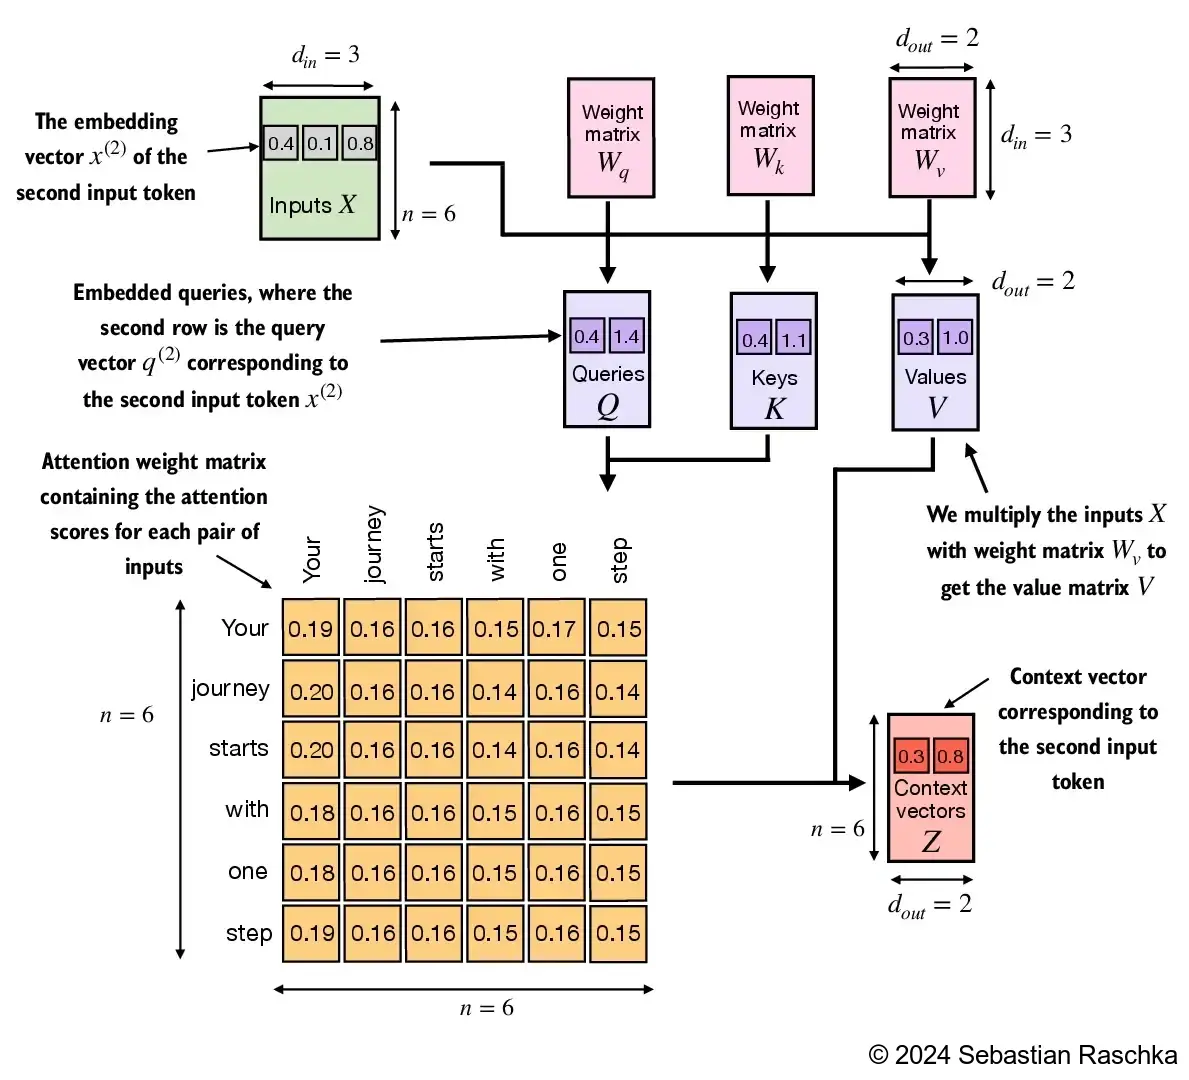

Usage of `nn.Linear` layers is preferred in the self attention class due to a more efficient implementation.

In [27]:
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias: bool = False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, qkv_bias) # (emb_size, attn_emb_size)
        self.W_key = nn.Linear(d_in, d_out, qkv_bias) # (emb_size, attn_emb_size)
        self.W_value = nn.Linear(d_in, d_out, qkv_bias) # (emb_size, attn_emb_size)

    def forward(self, x):
        queries = self.W_query(x) # (n_tokens, emb_size) X (emb_size, attn_emb_size) -> (n_tokens, attn_emb_size)
        keys = self.W_key(x) # (n_tokens, emb_size) X (emb_size, attn_emb_size) -> (n_tokens, attn_emb_size)
        values = self.W_value(x) # (n_tokens, emb_size) X (emb_size, attn_emb_size) -> (n_tokens, attn_emb_size)

        attn_scores = queries @ keys.T # (n_tokens, attn_emb_size) X (attn_emb_size, n_tokens) -> (n_tokens, n_tokens)
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim = -1
        )
        context_vectors = attn_weights @ values # (n_tokens, n_tokens) X (n_tokens, attn_emb_size) -> (n_tokens, attn_emb_size)
        return context_vectors

In [28]:
torch.manual_seed(789)

sa_v2 = SelfAttention_v2(d_in, d_out)

# Calculate context vectors
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


## Causal attention

Causal attention (*masked attention*) is used in order to create restrictions for a LM and force it to consider only previous tokens when generating the output. 

**Causal attention masks future tokens.**
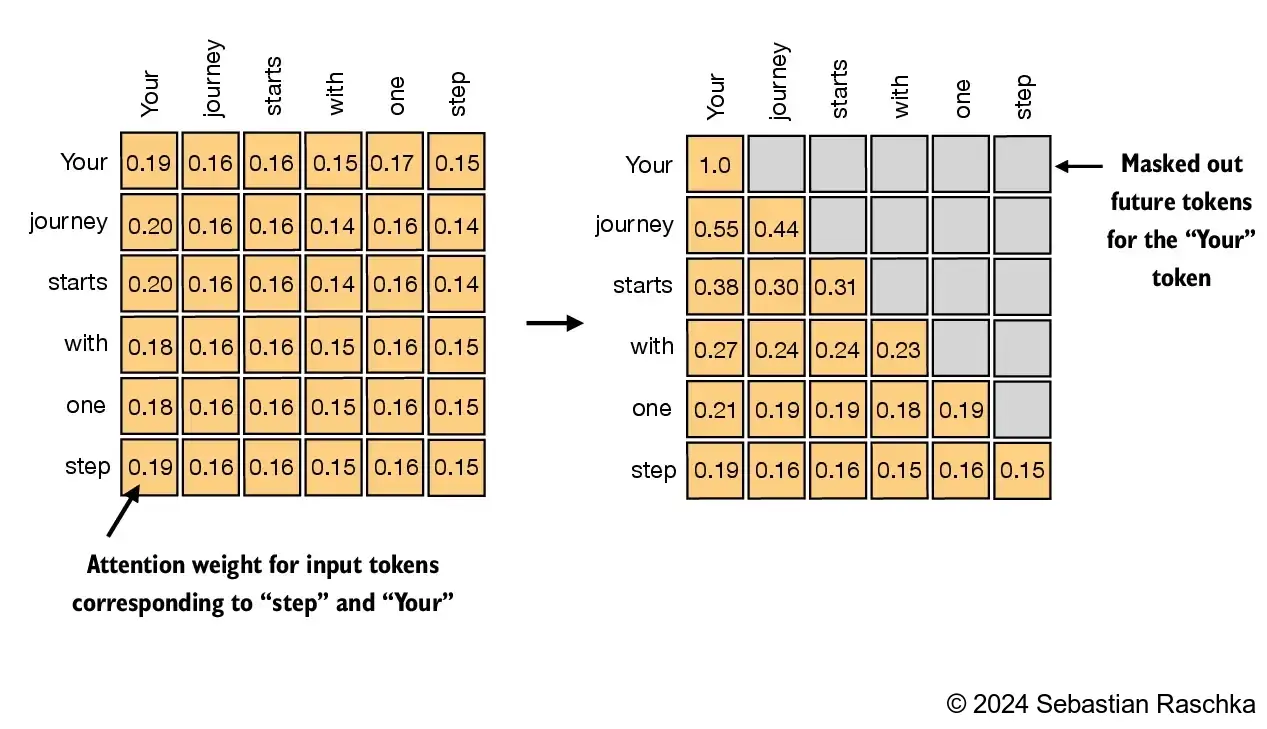